In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import correlate

In [ ]:
df =  pd.read_csv("./jikkenr160_0902.csv", header = 0, skiprows = 6)
sw =  pd.read_csv("./r160_f80_f02_P81newsweep.csv",names=('x', 'y'))

In [ ]:
df['X(mm)'] = df['X']*1000.0
df['Y(mm)'] = df['Y']*1000.0
df['Z(mm)'] = df['Z']*1000.0

9692


Text(0, 0.5, 'x, y [mm]')

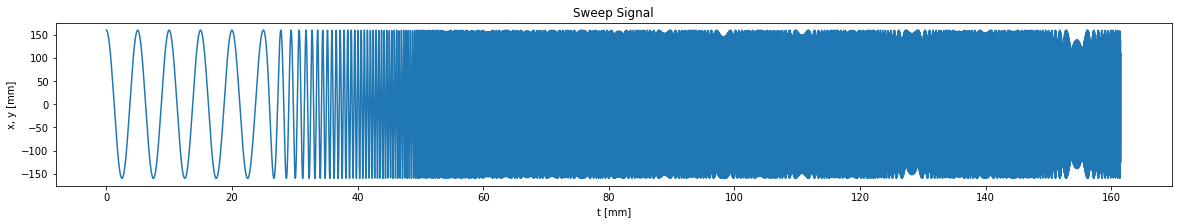

In [ ]:
fps_sweep = 60
n=len(sw['x'])
print(n)
t=np.linspace(0,n,n)/fps_sweep
plt.figure(figsize=(20,3))
plt.plot(t,sw['x'])
plt.title('Sweep Signal')
plt.xlabel('t [mm]')
plt.ylabel('x, y [mm]')

Text(0, 0.5, 'Frequency [Hz]')

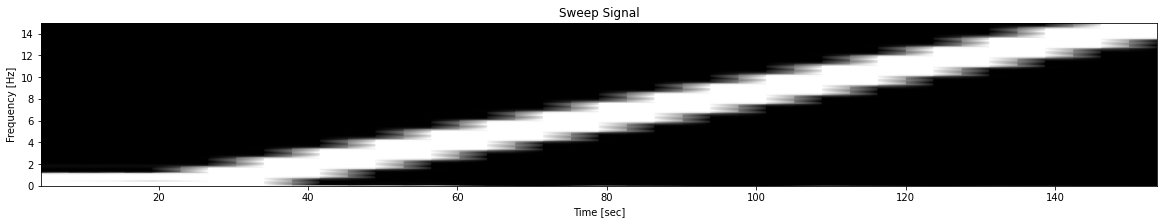

In [ ]:
plt.figure(figsize=(20,3))
f,t_,Sxx = signal.spectrogram(sw['x'], fps_sweep, nperseg=512)
ax = plt.gca()
ax.pcolormesh(t_, f, Sxx,vmax=1e+1, vmin=1e-17, shading='gouraud', cmap='gray') #coolwarm jet gray 
ax.set_ylim([0,fps_sweep/4])
plt.title('Sweep Signal')
ax.set_xlabel(u'Time [sec]')
ax.set_ylabel(u'Frequency [Hz]')

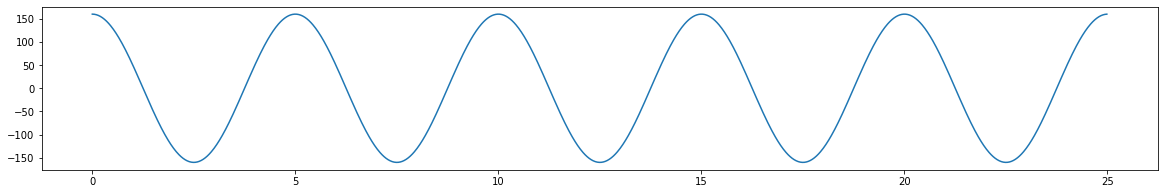

In [ ]:
plt.figure(figsize=(20,3))
cx = df['X(mm)'] - np.mean(df['X(mm)'])
cy = sw['x'][:fps_sweep * 5 * 5] - np.mean(sw['x'][:fps_sweep * 5 * 5])
ct = t[:fps_sweep * 5 * 5]
plt.plot(ct,cy)

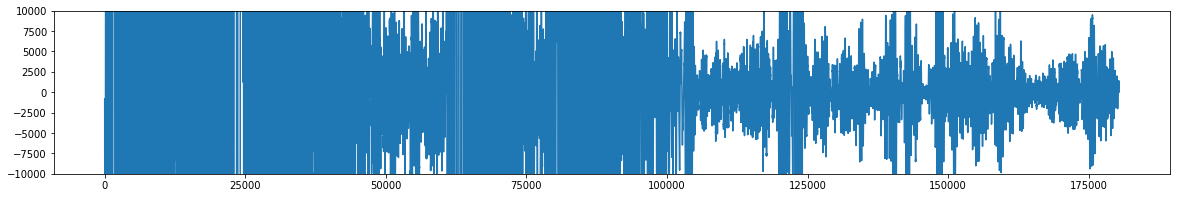

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(correlate( cx, cy))
plt.ylim([-10000,10000])
plt.show()

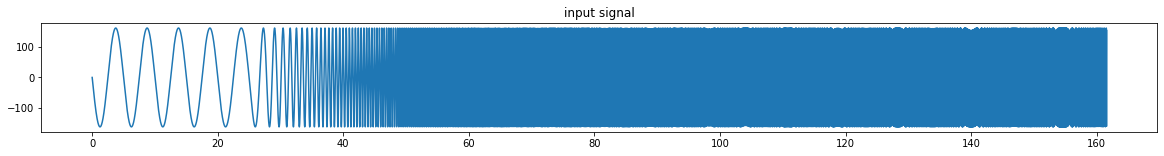

In [ ]:
r = 160 # [mm]

f_max =       8  #  Hz
f_min =     0.2  #  Hz
dulation_s = 25  # s

fps_opti =   120 # Hz

ns = fps_opti * dulation_s 
n  = 8196 * 2         # 8196 @ 60 fps = 8196 * 2 @ 120fps 

delta_f = (f_max - f_min) / n

t1 = np.linspace(0, ns, ns) / fps_opti
t2 = np.linspace(0, n, n) / fps_opti + dulation_s
tsx = np.append(t1,t2)
# (単位円の半径r)*(PI)*(時刻tにおける振動数f)*(時刻t)
sx120=[]
sx120 = -r * np.sin(2.0 * np.pi *  f_min * tsx[:ns])
sx120s= -r * np.sin(2.0 * np.pi * (f_min + delta_f * np.linspace(0,n,n)) * np.linspace(0,n,n)/fps_opti)
sx120 = np.append(sx120, sx120s)
plt.figure(figsize=(20,2))
plt.plot(tsx, sx120)
plt.title('input signal')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

        
def setname(i):
    # implemented from 
    # https://github.com/maeda-lab/Scaledown/blob/master/simulation/simulation_realtime_Ji_sending/Source.cpp

    # Order of names created... 1/4xy,yz,zx 1/8xy,yz,zx  1/16xy,yz,zx
    # by using "if" ,"%",and "/"
    
    name = 'scale_'

    # C++ source might have bug
    # the following arrangement should be correct
    # Masahiro Furukawa
    if i % 3 == 0:
        space = "xy" 
        movespace = 0
    elif i % 3 == 1:
        space = "yz"
        movespace = 1
    else:
        space = "zx"
        movespace = 2

    if int(i / 3) == 0: 
        scalesize = "1_4"
        scale = 0.25
        c = 'g'
    elif int(i / 3) == 1:
        scalesize = "1_8"
        scale = 0.125
        c = 'r'
    else:
        scalesize = "1_16"
        scale = 0.0625
        c = 'b'

    return (name + scalesize + space , scale, c)

In [ ]:
def Coordination_Opti2Robot(x,y,z):
    
    #    Robot : +X(to Front), +Y(to Left), +Z(to Top)
    # **  Opti : +Z(to Front), +X(to Left), +Y(to Top)
    
    return (z, x, y)

def prep_axis(ax, str, ssx, ssy, ssn, key_x):
    ax.plot(ssx, ssy, ssn, 'k.', alpha=0.2, label= key_x, markersize=1)
    ax.plot(ssx, ssn, 'k.', zdir='y', zs= 80  ,alpha=0.1, markersize=1)
    ax.plot(ssy, ssn, 'k.', zdir='x', zs=-80  ,alpha=0.1, markersize=1)
    ax.plot(ssx, ssy, 'k.', zdir='z', zs=-80  ,alpha=0.1, markersize=1)        
    ax.set_xlabel('Arm Position X [mm]')
    ax.set_ylabel('Arm Position Y [mm]')
    ax.set_zlabel('Arm Position Z [mm]')
    ax.set_xlim([-80, 80])
    ax.set_ylim([-80, 80])
    ax.set_zlim([-80, 80])
    ax.legend([str])

In [ ]:
def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 
    n = len(df[key_x])
    t = np.linspace(0,n,n)/fps_opti
    print(n)
    
    deltaSec = 160
    plotSec = 10
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,15))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (no re-scaled)', fontsize=30)
    
    for s in range(nTrial):
        
        str,_,_ = setname(s)
        
        (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])
        
        plt.subplot(3,3,s+1)
        plt.plot(t, z,'b-',alpha=0.9,label = key_z, markersize=3)
        plt.plot(t, x,'r-',alpha=0.9,label = key_x, markersize=3)
        plt.plot(t, y,'g-',alpha=0.9,label = key_y, markersize=3)
        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
#         plt.ylim([0,10])
        ts = start_in_sec[s]
        te = start_in_sec[s+1]
        plt.xlim([ts, te])
        plt.legend()
        plt.grid(True)
    
    plt.show()

    
    fig = plt.figure(figsize=(20,15))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (no re-scaled)', fontsize=30)
    
    for s in range(nTrial):
        
        str, scale, c = setname(s)
        
        skip_sec = 150
        draw_sec = 10
        
        ss = ( start_in_sec[s] + skip_sec ) * fps_opti
        es = ss + draw_sec * fps_opti
        # es = start_in_sec[s+1] *fps_opti
        
        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) )
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) 
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) )
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)
        
        ax = fig.add_subplot(331+s, projection='3d')
        
        ax.plot(x, y, z, c, alpha=0.7)
        
        ax.plot(x, z, 'k-', zdir='y', zs= 80  ,alpha=0.2, c=c)
        ax.plot(y, z, 'k-', zdir='x', zs=-80  ,alpha=0.2, c=c)
        ax.plot(x, y, 'k-', zdir='z', zs=-80  ,alpha=0.2, c=c)


        sx = sw['x'][:plotSec*fps_opti] * scale
        sy = sw['y'][:plotSec*fps_opti] * scale    
        sn = np.zeros(len(sx))
        if 'xy' in str:
            ssx = sx
            ssy = sy
            ssn = sn
            
        if 'yz' in str:
            ssx = sn
            ssy = sx
            ssn = sy

        if 'zx' in str:
            ssx = sx
            ssy = sn
            ssn = sy

        prep_axis(ax, str, ssx, ssy, ssn, key_x)

    fig = plt.figure(figsize=(20,15))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (RE-SCALED)', fontsize=30)
    
    for s in range(nTrial):
        
        str, scale, c = setname(s)
        
        ss = start_in_sec[s]   *fps_opti
        es = start_in_sec[s+1] *fps_opti
        
        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) ) / scale / 4.0
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) / scale / 4.0
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) ) / scale / 4.0
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)
        
        ax = fig.add_subplot(331+s, projection='3d')
        
        ax.plot(x, y, z, c, alpha=0.7)
        
        ax.plot(x, z, 'k-', zdir='y', zs= 80  ,alpha=0.2, c=c)
        ax.plot(y, z, 'k-', zdir='x', zs=-80  ,alpha=0.2, c=c)
        ax.plot(x, y, 'k-', zdir='z', zs=-80  ,alpha=0.2, c=c)
        
        sx = sw['x'][:plotSec*fps_opti]  / 4.0
        sy = sw['y'][:plotSec*fps_opti]  / 4.0
        sn = np.zeros(len(sx))

        if 'xy' in str:
            ssx = sx
            ssy = sy
            ssn = sn
            
        if 'yz' in str:
            ssx = sn
            ssy = sx
            ssn = sy

        if 'zx' in str:
            ssx = sx
            ssy = sn
            ssn = sy
        
        prep_axis(ax, str, ssx, ssy, ssn, key_x)
    fig = plt.figure(figsize=(10,7))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (RE-SCALED)', fontsize=30)
    
    ax = fig.add_subplot(111, projection='3d')
    
    for s in [0,3,6]:
        
        str, scale, c = setname(s)
        
        ss = start_in_sec[s]   *fps_opti
        es = start_in_sec[s+1] *fps_opti
        
        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) ) / scale / 4.0
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) / scale / 4.0
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) ) / scale / 4.0
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)
        
        ax.plot(x, y, z, c, alpha=0.6, label=str)

        ax.plot(x, z, 'k-', zdir='y', zs= 80  ,alpha=0.2, c=c)
        ax.plot(y, z, 'k-', zdir='x', zs=-80  ,alpha=0.2, c=c)
        ax.plot(x, y, 'k-', zdir='z', zs=-80  ,alpha=0.2, c=c)

        sx = sw['x'][:plotSec*fps_opti] / 4.0
        sy = sw['y'][:plotSec*fps_opti] / 4.0
        sn = np.zeros(len(sx))
        
        if 'xy' in str:
            ssx = sx
            ssy = sy
            ssn = sn
            
        if 'yz' in str:
            ssx = sn
            ssy = sx
            ssn = sy

        if 'zx' in str:
            ssx = sx
            ssy = sn
            ssn = sy       

        prep_axis(ax, str, ssx, ssy, ssn, key_x)

    plt.tight_layout()
    plt.show()
    

178928


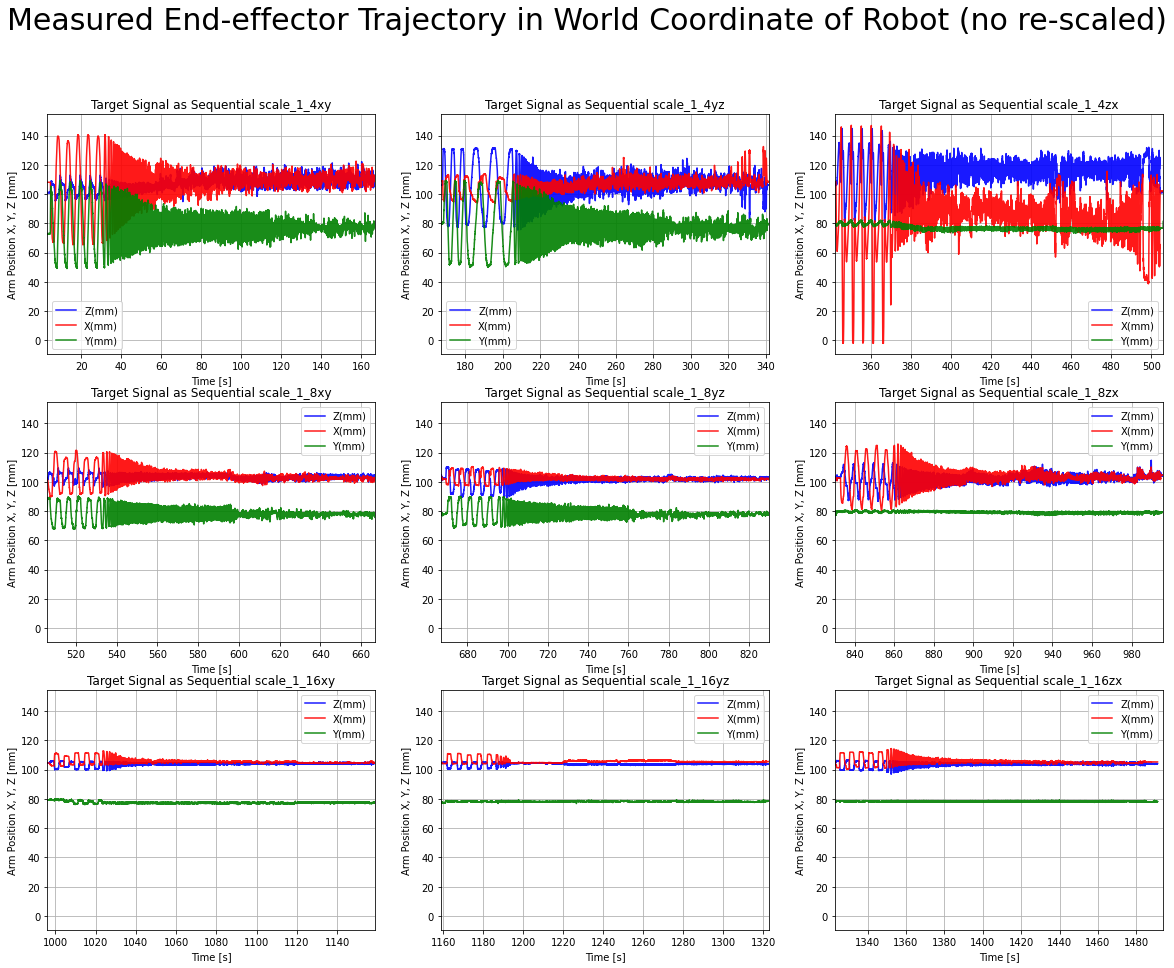

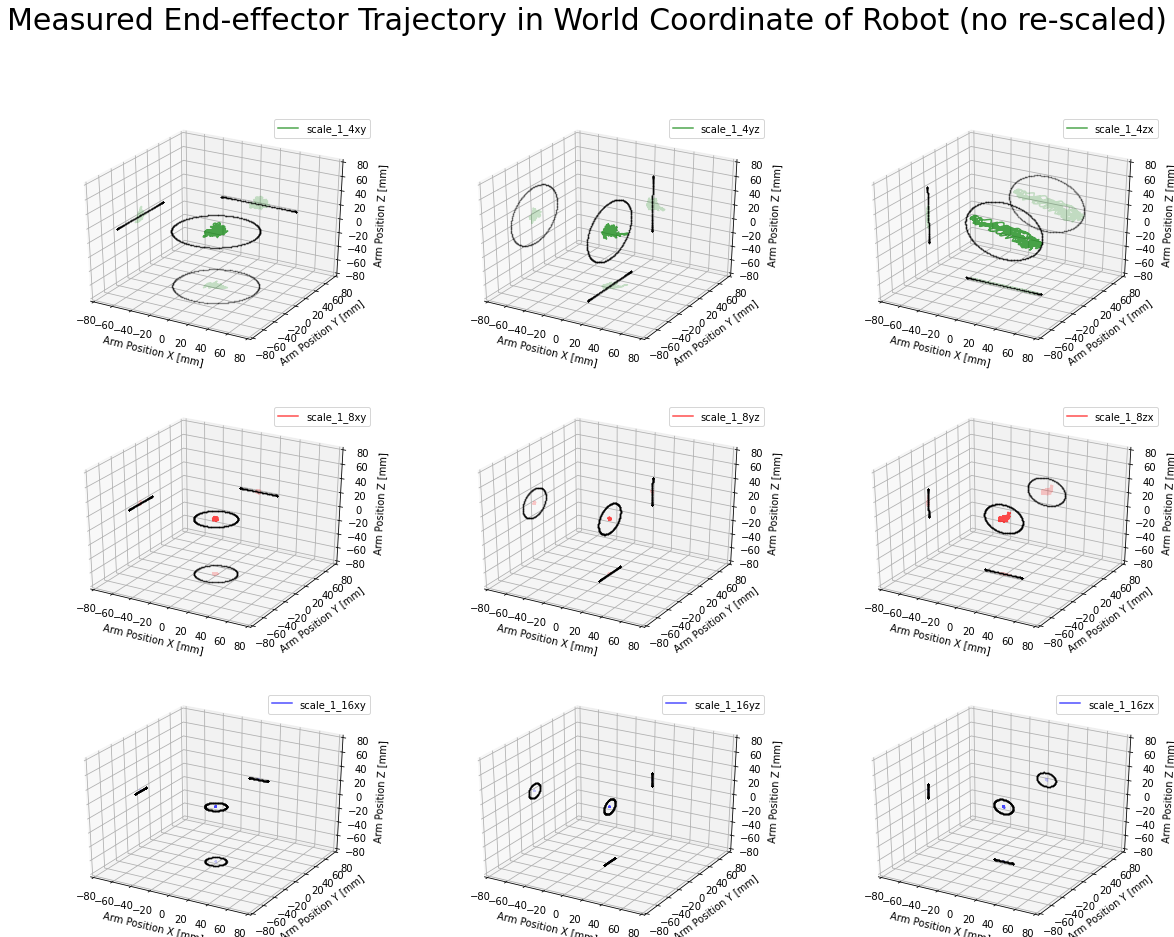

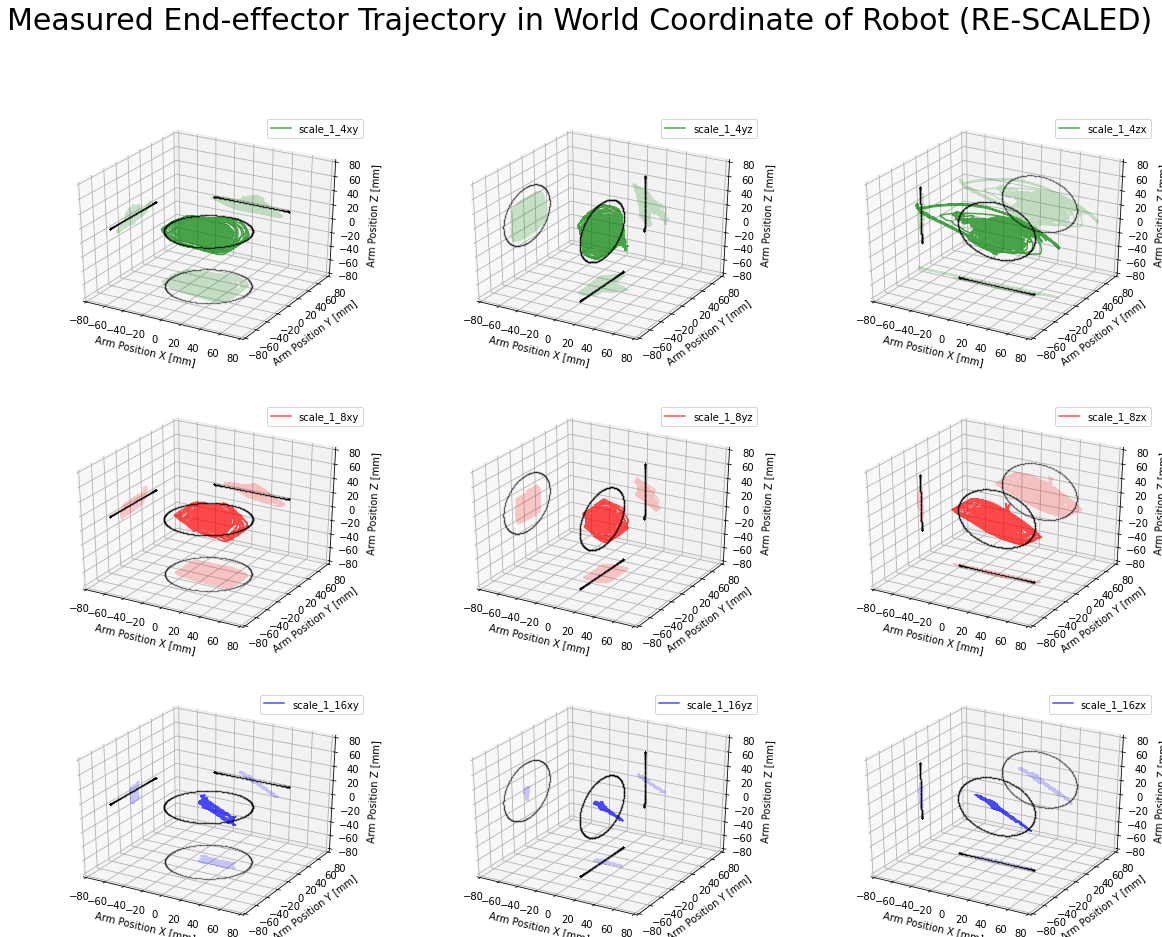

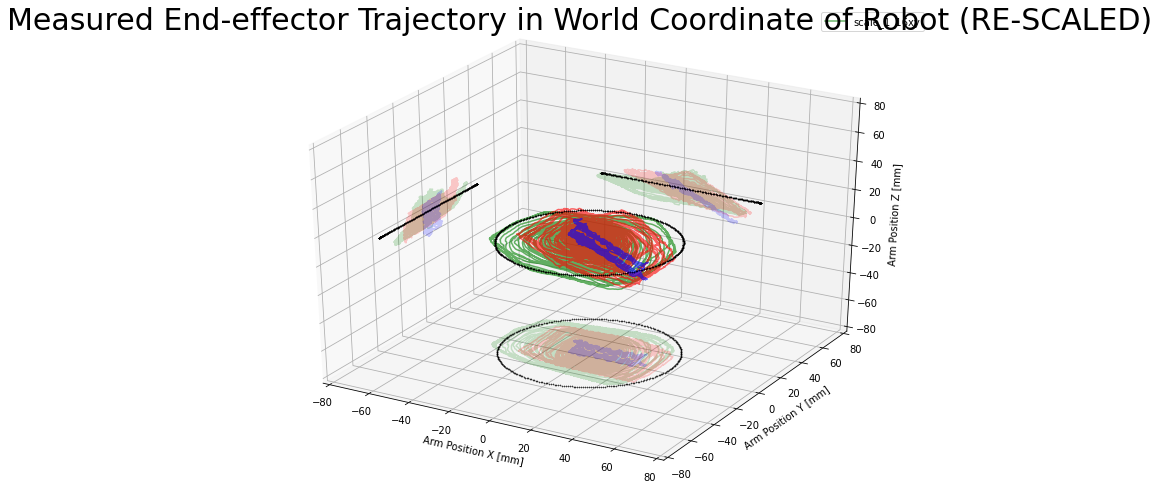

In [ ]:
start_in_sec = [3, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')

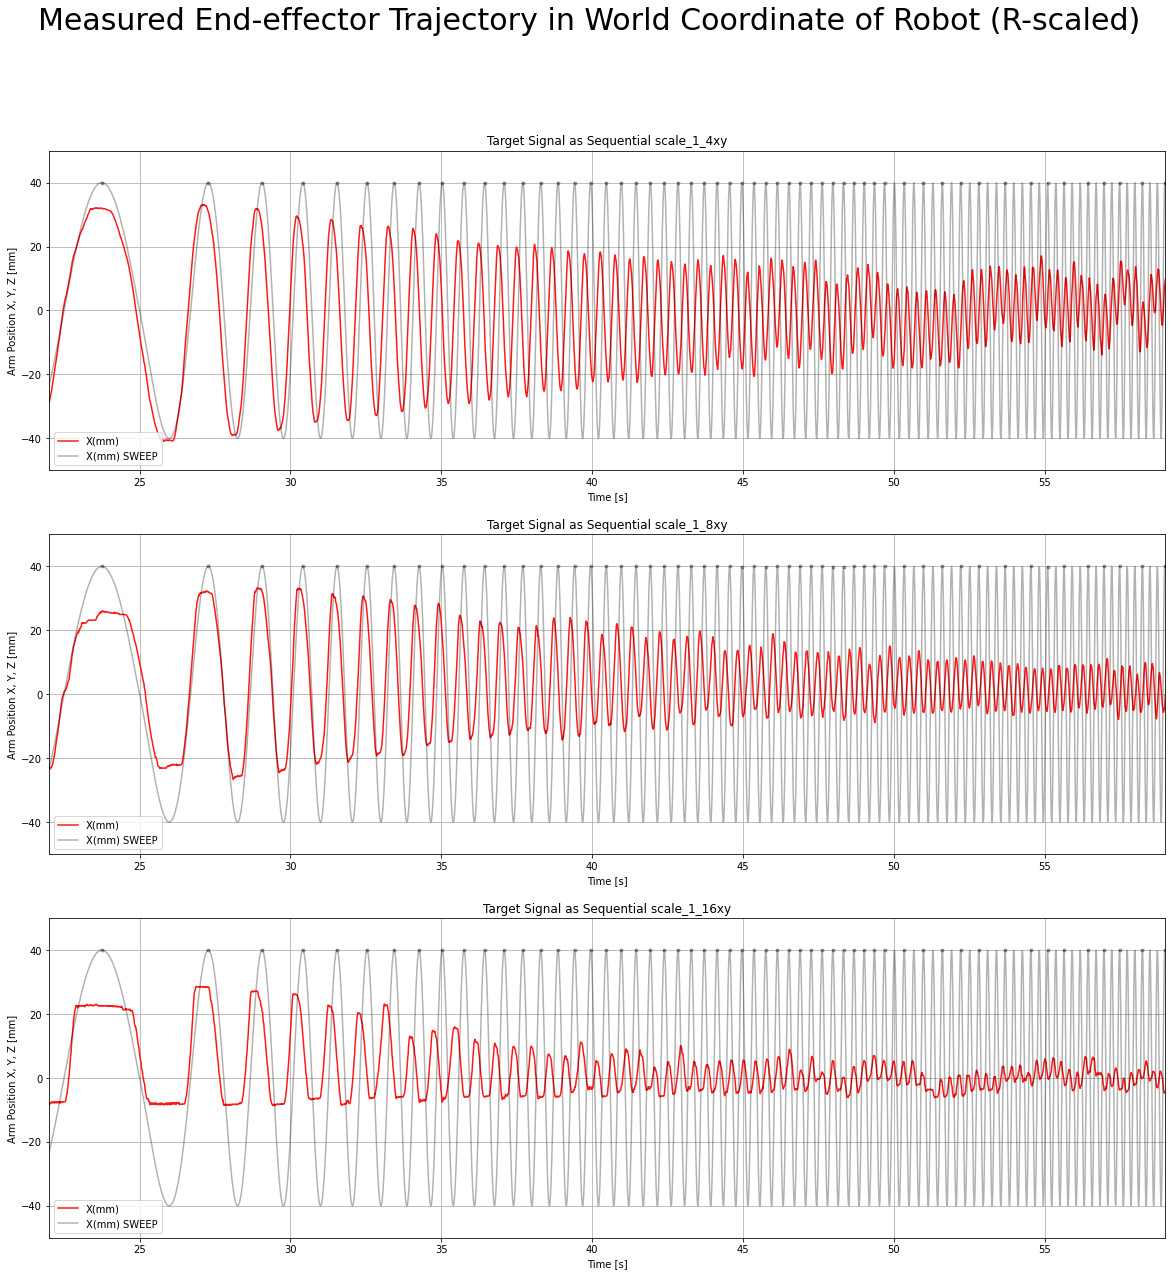

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import find_peaks
from scipy.signal import correlate

#define wave's start Point by using sec.
start_in_sec = [5, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6+1, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
mod_in_sec = [.2, 0, 0, -.3, 0, 0, .15, 0, 0]

#    Robot : +X(to Front), +Y(to Left), +Z(to Top)
# **  Opti : +Z(to Front), +X(to Left), +Y(to Top)
def Coordination_Opti2Robot(x,y,z):
    return (z, x, y)

def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 162
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])

    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        xx = list(x[ts*fps_opti : te*fps_opti])
        xx = xx - np.mean(xx)
        
        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(sx120),len(sx120))/fps_opti
        
        peaks_xx, _ = find_peaks(xx,    distance=40)
        peaks_sx, _ = find_peaks(sx120, distance=40)
#         acf = correlate(x,x)[acTSec*fs:]

        plt.subplot(3,1,int(s/3)+1)
    
        for i, pi in enumerate(peaks_sx):
            if i == 0 or pi > 6000: 
                continue
                
            w = int((peaks_sx[i] - peaks_sx[i-1])/1.5)
            pis = -w + peaks_sx[i-1]
            pie =  w + peaks_sx[i-1]
#             cor = correlate(xx[pis:pie], sx120[pis:pie])
#             ic = np.argmax(cor)
            
#             plt.figure()
#             plt.plot(cor)
#             plt.plot(ic, cor[ic], 'bo', alpha=0.9, markersize=6)
#             print(i,pi,peaks_sx[i] - peaks_sx[i-1],t[pis],t[pie])
#             plt.plot(t[ic+pis] ,xx[ic+pis], 'bo', alpha=0.9, markersize=6)
#             plt.hlines(t[pis]/10-20, t[pis], t[pie], 'gray', alpha=0.9) # **
#             print(i, cor[i], cor)

#             if i == 1: 
#                 dfix = ts[ic]
            
#         plt.plot(t           , xx,                   'r-', alpha=0.9, label = key_x,          markersize=2)
#         plt.plot(ts          , sx120*scale,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
#         plt.plot(ts[peaks_sx], sx120[peaks_sx]*scale,'ko', alpha=0.3,                         markersize=3)

        plt.plot(t+mod_in_sec[s]           , xx/(4*scale),                   'r-', alpha=0.9, label = key_x,          markersize=2)
        plt.plot(ts          , sx120/4,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
        plt.plot(ts[peaks_sx], sx120[peaks_sx]/4,'ko', alpha=0.3,                         markersize=3)
        
        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
        plt.xlim([22,deltaSec/3+5])
        plt.ylim([-50,50])
        plt.legend()
        plt.grid(True)


#     plt.tight_layout()
    plt.show()
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')

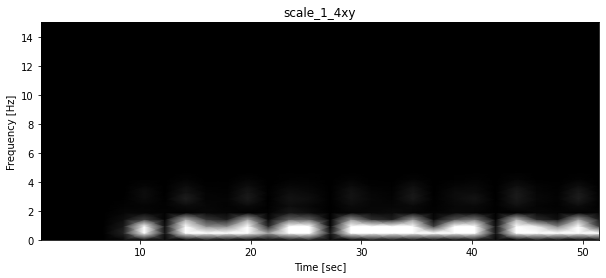

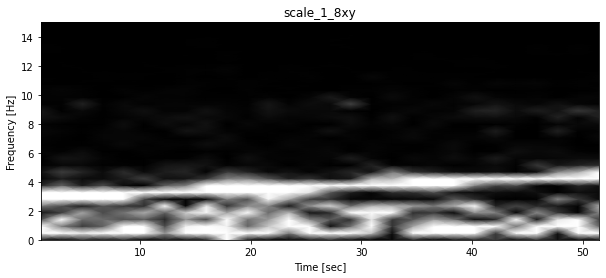

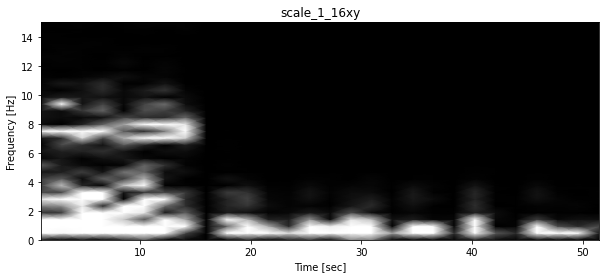

In [ ]:
# Masahiro Furukawa
# Aug 31, 2020

# Spectrogram

## coding:utf-8
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import fftpack

def plot_Spec(key_x, key_y, key_z):
    
    for s in [0,3,6]:

        fps_opti = 60
        deltaSec = 53
        
        str, scale, c = setname(s)

        ss = s*deltaSec*fps_opti
        es = (s+1)*deltaSec*fps_opti

        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) ) / scale / 4.0
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) / scale / 4.0
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) ) / scale / 4.0
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)

        fig = plt.figure(figsize=(10,4))

        vmx = [1e-9, 5*1e-7]
        vmn = [1e-11, 1e-8]

        # spectrogram
        f,t_,Sxx = signal.spectrogram(x, fps_opti, nperseg=128)
        ax = plt.gca()
        ax.pcolormesh(t_, f, Sxx,vmax=1e+1, vmin=1e-17, shading='gouraud', cmap='gray') #coolwarm jet gray 
        # ax.set_xlim([150,400])
        ax.set_ylim([0,fps_opti/4])
        ax.set_title(str)
        ax.set_xlabel(u'Time [sec]')
        ax.set_ylabel(u'Frequency [Hz]')

plot_Spec('X(mm)', 'Y(mm)', 'Z(mm)')

In [ ]:
# 2020 09 08 TomokiHirayama
# 2020 09 11 TomokiHirayama    create peaks
# 2020 09 13 TomokiHirayama    create function :set_clear

#define wave's start Point by using sec.
start_in_sec = [5, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6+1, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
mod_in_sec = [.2, 0, 0, -.3, 0, 0, .15, 0, 0]

#    Robot : +X(to Front), +Y(to Left), +Z(to Top)
# **  Opti : +Z(to Front), +X(to Left), +Y(to Top)


#バターワースフィルタ（ローパス）
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す

def set_clear(ts , xx,peaks_xx):
    #calcurate delta_xx
    #time : time data
    #xx : x data
    #peaks_xx : peak Point data
    remain_list=[]# make remain list :  number(peaks_xx)
    
    threshold = 1.0
    start_i=0
    end_i=0
    #pxsize=peaks_xx.size
    #tsize=t.size
    #for tmp in peaks_xx.tolist():
    #for tmp in range(pxsize-1):
    for tmp in range(len(peaks_xx)):
        #print(range(pxsize-1))
        if (peaks_xx[tmp]
            > 
            len(ts)):
            break        
        elif(tnp[peaks_xx[tmp]]<25.0):# if befor 25.0 , there is no using data
            continue 
        elif( (xx[peaks_xx[tmp+1]] - xx[peaks_xx[tmp]])> threshold):
                remain_list=np.append(peaks_xx[tmp])
        elif( (xx[peaks_xx[tmp+1]] - xx[peaks_xx[tmp]])< threshold):
            start_i=tmp
            for cnt in range(pxsize/10):
                if((xx[peaks_xx[tmp+cnt+1]] - xx[peaks_xx[tmp+cnt]])> threshold):
                    end_i=tmp+cnt
            if(end_i-start_i==1):
                    remain_list=np.append(peaks_xx[start_i])
                    start_i=0
                    end_i=0
            else:
                remain_list=np.append(peaks_xx[int((start_i+end_i)/2)])
                start_i=0
                end_i=0

    print(remain_list)
    return remain_list            
    




def plot_analyze_x(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 162
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])

    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        # xx : axis-x data
        xx = list(x[ts*fps_opti : te*fps_opti])
        xx = xx - np.mean(xx)
        #offset
        offset=sum(xx)
        print(offset)
        xx=xx-offset
        xx = xx/(4*scale)
        gpass=3
        gstop=40
        xx=lowpass(xx,fps_opti , f_max, f_max*0.5, gpass, gstop)
        # ys : time data
        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(sx120),len(sx120))/fps_opti
        
        #peaks_xx, _ = find_peaks(xx,    distance=40)
        #peaks_sx, _ = find_peaks(sx120, distance=1)

        max_xx = signal.argrelmax(xx, order=1)
        min_xx = signal.argrelmin(xx, order=20)
        max_sx = signal.argrelmax(sx120, order=1)
        min_sx = signal.argrelmin(sx120, order=1)

        peaks_xx=np.sort(np.hstack((max_xx,min_xx)))
        peaks_sx=np.sort(np.hstack((max_sx,min_sx)))


        #print(peaks_xx)

        #peaks_xx = set_clear(ts,xx,peaks_xx)


        remain_list=[]# make remain list :  number(peaks_xx)
    
        threshold = 3.0
        start_i=0
        end_i=0
        len_ts=len(ts)
        pxsize=len(peaks_xx[0])
        print(pxsize)
        for tmp in range(pxsize):
            #print(peaks_xx)
            #print(peaks_xx[0][tmp])
            #if (peaks_xx[0][tmp]>len_ts):
            if (peaks_xx[0][tmp]>len_ts):
                print(tmp)
                print("break")
                break        
            elif(ts[peaks_xx[0][tmp]]<25.0):# if befor 25.0 , there is no using data
                a=1 
            elif( (xx[peaks_xx[0][tmp+1]] - xx[peaks_xx[0][tmp]])> threshold):
                remain_list=np.append(remain_list,peaks_xx[0][tmp])
            elif( (xx[peaks_xx[0][tmp+1]] - xx[peaks_xx[0][tmp]])< threshold):
                start_i=tmp
                for cnt in range(int(pxsize/10)):
                    if(tmp+cnt+1>=pxsize):
                        end_i=tmp+cnt
                        break;
                    elif((xx[peaks_xx[0][tmp+cnt+1]] - xx[peaks_xx[0][tmp+cnt]])> threshold):
                        end_i=tmp+cnt
                if(end_i-start_i==1):
                    remain_list=np.append(remain_list,peaks_xx[0][start_i])
                    start_i=0
                    end_i=0
                else:
                    remain_list=np.append(remain_list,peaks_xx[0][int((start_i+end_i)/2)])
                    start_i=0
                    end_i=0
        print(remain_list)

        plt.subplot(3,1,int(s/3)+1)
        plt.plot(t+mod_in_sec[s]           , xx,                   'r-', alpha=0.9, label = key_x,          markersize=2)
        plt.plot(ts          , sx120/4,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
        
        #plt.plot(t[peaks_xx]+mod_in_sec[s] , xx[peaks_xx], 'ko', alpha=0.3, markersize=2)
        #plt.plot(ts[peaks_sx],               sx120[peaks_sx]/4,      'ko', alpha=0.3, markersize=3)
        plt.plot(t[remain_list]+mod_in_sec[s] , xx[remain_list], 'ko', alpha=0.3, markersize=2)
        plt.plot(ts[remain_list],               sx120[remain_list]/4,      'ko', alpha=0.3, markersize=3)
        
        #plt.plot(t[max_xx]+mod_in_sec[s] , xx[max_xx]/(4*scale), 'ko', alpha=0.3, markersize=2)
        #plt.plot(t[min_xx]+mod_in_sec[s] , xx[min_xx]/(4*scale), 'ko', alpha=0.3, markersize=2)
        
        #plt.plot(ts[max_sx],               sx120[max_sx]/4,      'ko', alpha=0.3, markersize=3)
        #plt.plot(ts[min_sx],               sx120[min_sx]/4,      'ko', alpha=0.3, markersize=3)

        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
        plt.xlim([22,deltaSec/3+5])
        plt.ylim([-50,50])
        plt.legend()
        plt.grid(True)
#     plt.tight_layout()
    plt.show()

plot_analyze_x('X(mm)', 'Y(mm)', 'Z(mm)')

-1.8816592728398973e-10
[[  102   107   132   170   380   399   418   709   719   739   759   771
   1003  1019  1305  1323  1347  1359  1370  1593  1615  1903  1923  1946
   1959  1971  2194  2215  2505  2515  2525  2550  2573  2784  2801  2821
   3073  3082  3097  3106  3232  3344  3352  3439  3528  3601  3676  3739
   3805  3856  3917  3964  4019  4064  4113  4156  4204  4243  4287  4324
   4367  4402  4443  4476  4515  4548  4585  4616  4652  4682  4716  4745
   4778  4808  4840  4868  4899  4926  4956  4983  5012  5038  5066  5092
   5120  5145  5172  5198  5224  5248  5274  5298  5323  5346  5372  5394
   5419  5442  5465  5489  5512  5533  5556  5577  5600  5622  5644  5665
   5689  5708  5730  5750  5772  5791  5812  5833  5854  5874  5893  5912
   5933  5952  5973  5991  6012  6029  6050  6068  6088  6105  6124  6142
   6162  6179  6198  6215  6234  6254  6271  6289  6307  6325  6342  6361
   6377  6394  6411  6427  6445  6462  6480  6496  6513  6530  6545  6563
   6580  6596 

ValueError: ignored

<Figure size 1440x1440 with 0 Axes>